In [1]:
!pip install -e /home/aku7cf/DREAMS/DREAMS_python
# !pip install -e /path/to/DREAMS_python

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///home/aku7cf/DREAMS/DREAMS_python
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for dreams_python (pyproject.toml) ... done
  Created wheel for dreams_python: filename=dreams_python-0.1.0-0.editable-py3-none-any.whl size=4485 sha256=4e7b7e316432fa257d05589e99d9ca2428b85e3c135521b54a128ae35d08dcee
  Stored in directory: /tmp/pip-ephem-wheel-cache-_l9ispwt/wheels/93/9c/36/d4c59b3fc31ec2b5dc143e4a986198ab2224d05d41a91e194c
Successfully built dreams_python
  Attempting uninstall: dreams_python
    Found existing installation: dreams_python 0.1.0
    Uninstalling dreams_python-0.1.0:
      Successfully uninstalled dreams_python-0.1.0


In [2]:
import dreams_python
import numpy as np
import matplotlib.pyplot as plt

## Load in entire Consistent Trees Catalog

In [64]:
rvs = dreams_python.DREAMS('/standard/DREAMS',suite='varied_mass',DM_type='CDM',sobol_number=9, box_or_run='run')

In [280]:
run  = 0
snap = 90

In [281]:
ct = rvs.read_consistent_trees(run)
print('Consistent Trees Keys:')
print(ct.keys())

Consistent Trees Keys:
dict_keys(['scale', 'id', 'desc_scale', 'desc_id', 'num_prog', 'pid', 'upid', 'desc_pid', 'phantom', 'sam_Mvir', 'Mvir', 'Rvir', 'rs', 'vrms', 'mmp', 'scale_of_last_MM', 'vmax', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'Jx', 'Jy', 'Jz', 'Spin', 'Breadth_first_ID', 'Depth_first_ID', 'Tree_root_ID', 'Orig_halo_ID', 'Snap_idx', 'Next_coprogenitor_depthfirst_ID', 'Last_progenitor_depthfirst_ID', 'Last_mainleaf_depthfirst_ID', 'Tidal_Force', 'Tidal_ID', 'Rs_Klypin', 'Mvir_all', 'M200b', 'M200c', 'M500c', 'M2500c', 'Xoff', 'Voff', 'Spin_Bullock', 'b_to_a', 'c_to_a', 'Ax', 'Ay', 'Az', 'b_to_a500c', 'c_to_a500c', 'Ax500c', 'Ay500c', 'Az500c', 'TU', 'M_pe_Behroozi', 'M_pe_Diemer', 'Type', 'SM', 'Gas', 'BH_Mass'])


## Get halo's main progenitor branch

The "main progenitor branch" (mpb) are the most massive progenitors of a particular subhalo at each individual snaphsot.

Note that the main progenitor branch is not guarenteed to exist for all subhalos

In [282]:
## First identify target
params, header = rvs.read_param_file('TNG_SB9.txt')
target_masses = params[:, 0]

central_idx = rvs.get_target_rockstar_index(run, snap, target_masses[run])

mpb = rvs.get_consistent_trees_mpb(run, snap, subhalo_idx=central_idx)

In [283]:
print(mpb['scale'])

[1.      0.97716 0.95372 0.93194 0.90959 0.88829 0.86749 0.84718 0.82784
 0.80845 0.78952 0.77104 0.74898 0.73145 0.71432 0.69801 0.68167 0.66531
 0.64974 0.6349  0.61967 0.60516 0.59169 0.57715 0.56364 0.55045 0.5382
 0.52559 0.51268 0.50127 0.48953 0.47807 0.46688 0.45595 0.44317 0.43485
 0.42216 0.41227 0.4031  0.3932  0.38445 0.37544 0.36622 0.35765 0.34969
 0.3415  0.3335  0.3257  0.31769 0.31025 0.30335 0.29625 0.28931 0.28254
 0.27592 0.26978 0.26284 0.25669 0.25008 0.24307 0.23626 0.22964 0.2232
 0.21643 0.21187 0.20593 0.20016 0.19455 0.18865 0.18379 0.17822 0.1724
 0.16678 0.16058 0.15424 0.1485  0.14298]


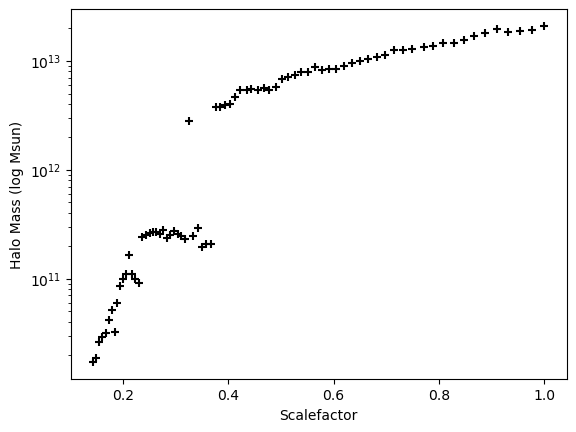

In [284]:
h = rvs.get_h(run, snap)
plt.scatter( mpb['scale'], mpb['Mvir']/h, color='k', marker='+' )

plt.xlabel('Scalefactor')
plt.ylabel('Halo Mass (log Msun)')

plt.yscale('log')

plt.show()

## Full Merger Tree associated with object

In [285]:
full_tree = rvs.get_consistent_tree(run, snap, subhalo_idx=central_idx)

In [286]:
print(full_tree['scale'].shape)

(260,)


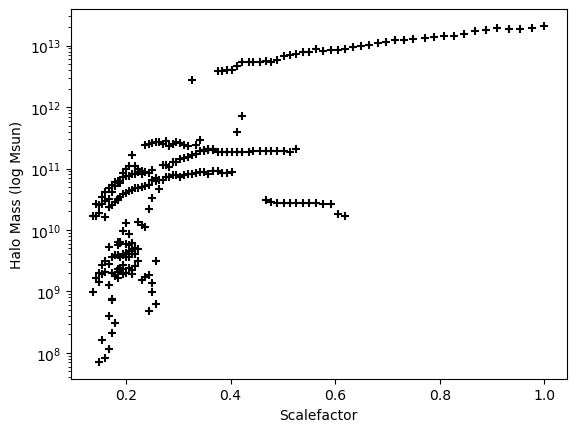

In [287]:
h = rvs.get_h(run, snap)
plt.scatter( full_tree['scale'], full_tree['Mvir']/h, color='k', marker='+' )

plt.xlabel('Scalefactor')
plt.ylabel('Halo Mass (log Msun)')

plt.yscale('log')

plt.show()

### Make plot of whole merger tree

This plot is based on [Leisher+2025](https://ui.adsabs.harvard.edu/abs/2025arXiv251105367L/abstract) Figure 1 (with some modifications to attempt to make a similar one with consistent trees)

In [297]:
def find_progenitors(ct, halo_id):
    return np.where(ct['desc_id'] == halo_id)[0]

def assign_tree_x_unique(ct, idx, xpos, current_x, x_counter):
    xpos[idx] = current_x

    progs = find_progenitors(ct, ct['id'][idx])
    if len(progs) == 0:
        return

    # main progenitor stays on same branch
    main = progs[np.argmax(ct['Mvir'][progs])]
    assign_tree_x_unique(ct, main, xpos, current_x, x_counter)

    # every other progenitor starts a NEW branch
    for p in progs:
        if p == main:
            continue

        x_counter[0] -= 1          # allocate new unique x
        new_x = x_counter[0]
        assign_tree_x_unique(ct, p, xpos, new_x, x_counter)

def ct_to_sublink_like(ct, root_idx):
    xpos = {}
    x_counter = [-1]   # mutable global counter
    assign_tree_x_unique(ct, root_idx, xpos, current_x=0, x_counter=x_counter)

    nodes = np.array(sorted(xpos.keys()), dtype=int)

    return nodes, xpos

In [298]:
rockstar_cat = rvs.read_rockstar(run, snap)

Mvir_rs = rockstar_cat['Mvir'][central_idx]

ct = rvs.read_consistent_trees(run)
scf = rvs.get_scf(run, snap)

this_snap  = int(ct['Snap_idx'][np.isclose(ct['scale'], scf)][0])
ids        = np.arange(len(ct['Snap_idx'])).astype(int)
snap_mask  = (ct["Snap_idx"] == this_snap)    
mass_match = np.argmin(np.abs( np.log10(ct['Mvir'][snap_mask]) - np.log10(Mvir_rs) ))
ct_id      = ids[snap_mask][mass_match]

root_id = int(ct['id'][ct_id])
idx = np.where( ct['id'] == root_id )[0][0]
nodes, xpos = ct_to_sublink_like(ct, idx)

In [299]:
scfs   = ct['scale'][nodes]
roots  = np.array([xpos[n] for n in nodes]) #+ len(xpos.keys())
masses = ct['Mvir'][nodes]

colors = np.log10(masses/h)
sizes  = masses / 1e+10

In [300]:
def get_edges(subid, desid):
    edges = []
    for i in range(len(subid)):
        for j in range(len(desid)):
            if subid[i] == desid[j]:
                edges.append((i, j))
    return edges

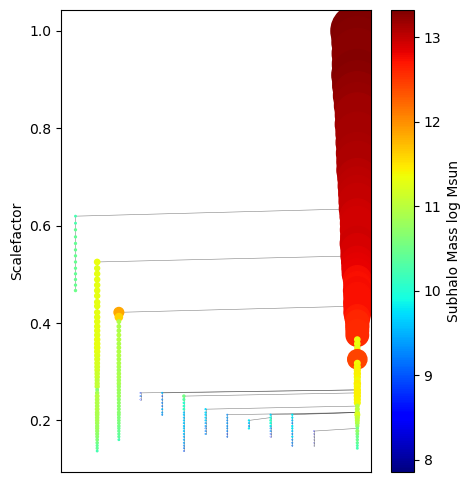

In [301]:
fig, ax = plt.subplots(figsize=(5, 6))

edges = get_edges(ct['id'][nodes], ct['desc_id'][nodes])

# Draw edges
for src, dst in edges:
    ax.plot([roots[src], roots[dst]], [scfs[src], scfs[dst]], color='black', linewidth=0.4, alpha=0.5, zorder=1)

sc = ax.scatter(roots, scfs, s=sizes, c=colors, cmap='jet', alpha=1.0, zorder=2)

ax.set_ylabel("Scalefactor")
ax.set_xticks([])
ax.tick_params(axis='y')

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Subhalo Mass log Msun")

plt.show()